# 1. Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 변수 정의해놓기

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


# 2. 데이터 가져오기

In [3]:
# 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames)) # val이 너무 적음 -> 직접 나눠주자

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1062-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1097
Pneumonia images count in training set: 3088


In [7]:
# tf.data 인스턴스 생성 -> mini-batch로 작업

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
# AUTOTUME : 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) # 고정 크기 버퍼 유지, 무작위로 선택
    ds = ds.repeat() # 여러번 데이터셋을 사용할 수 있게 해줌
    ds = ds.batch(BATCH_SIZE) # BATCH_SIZE만큼 batch 가져옴
    ds = ds.prefetch(buffer_size=AUTOTUNE) # 학습 데이터를 나눠서 읽어어옴
    # 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다.
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 3. 데이터 시각화

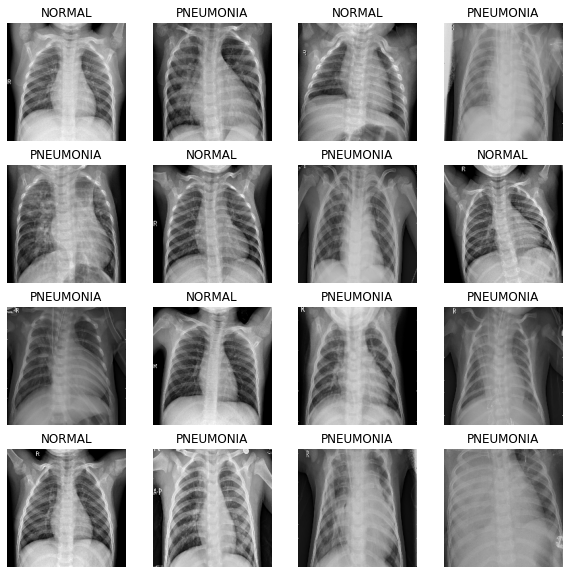

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN 모델링

In [51]:
def conv_block(filters, block_name):
    
    block = tf.keras.Sequential(name=block_name)  
    
    block.add(tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=1, activation='relu', padding='same'))
    block.add(tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=1, activation='relu', padding='same'))
    block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.MaxPool2D())
        
    return block

In [52]:
def dense_block(units, dropout_rate, block_name):
    
    block = tf.keras.Sequential(name=block_name)  

    block.add(tf.keras.layers.Dense(units, activation='relu'))
    block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.Dropout(dropout_rate))
    
    # BatchNormalization과 Dropout을 같이 써도 될까?
    
    return block

In [53]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu',  padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32, 'conv_block1'),
        conv_block(64, 'conv_block2'),
        
        conv_block(128, 'conv_block3'),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256, 'conv_block4'),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7, 'dense_block1'),
        dense_block(128, 0.5, 'dense_block2'),
        dense_block(64, 0.3, 'dense_block3'),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [54]:
model = build_model()

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv_block1 (Sequential)     (None, 45, 45, 32)        14016     
_________________________________________________________________
conv_block2 (Sequential)     (None, 22, 22, 64)        55680     
_________________________________________________________________
conv_block3 (Sequential)     (None, 11, 11, 128)       221952    
_________________________________________________________________
dropout_30 (Dropout)         (None, 11, 11, 128)     

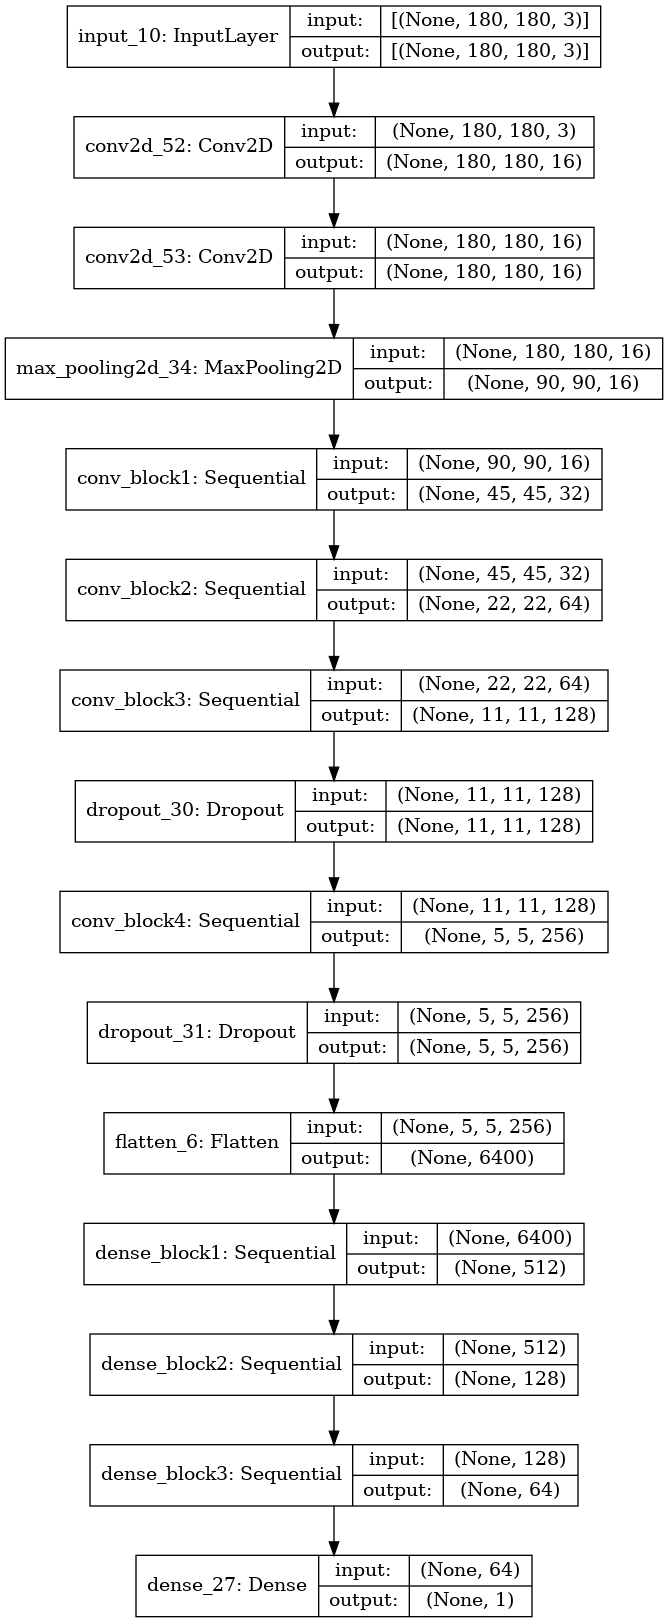

In [55]:
tf.keras.utils.plot_model(model, show_shapes=True)

# 5. 데이터 imbalance 처리

In [19]:
# Weight balancing 테크닉 사용

# 데이터셋이 많으면 더 적게 반영하도록 (데이터셋이 많은 쪽으로 모델이 학습하려 하니까)
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0  # Normal이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0 # Pneumonia 이미지에 사용할 weight

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


# 6. 모델 훈련

In [20]:
with tf.device('/GPU:0'): # GPU 선택
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 139s 377ms/step - loss: 0.3929 - accuracy: 0.8252 - precision: 0.9577 - recall: 0.8005 - val_loss: 0.7212 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 99s 380ms/step - loss: 0.2487 - accuracy: 0.9030 - precision: 0.9731 - recall: 0.8945 - val_loss: 1.1848 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 99s 382ms/step - loss: 0.2110 - accuracy: 0.9195 - precision: 0.9776 - recall: 0.9129 - val_loss: 1.0119 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 103s 396ms/step - loss: 0.1917 - accuracy: 0.9248 - precision: 0.9774 - recall: 0.9200 - val_loss: 0.4902 - val_accuracy: 0.8471 - val_precision: 0.9951 - val_recall: 0.7953
Epoch 5/10
261/261 [==============================] - 103s 397ms/step - loss: 0.1820 - acc

In [ ]:
# 모델 저장하기
model.save('basic_model.h5')

# 7. 결과 확인

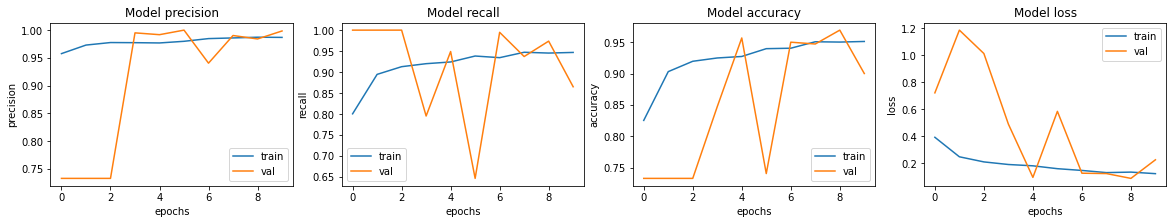

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 7s 127ms/step - loss: 0.4466 - accuracy: 0.8574 - precision: 0.8492 - recall: 0.9385
Loss: 0.4465865194797516,
Accuracy: 0.8573718070983887,
Precision: 0.8491879105567932,
Recall: 0.9384615421295166
